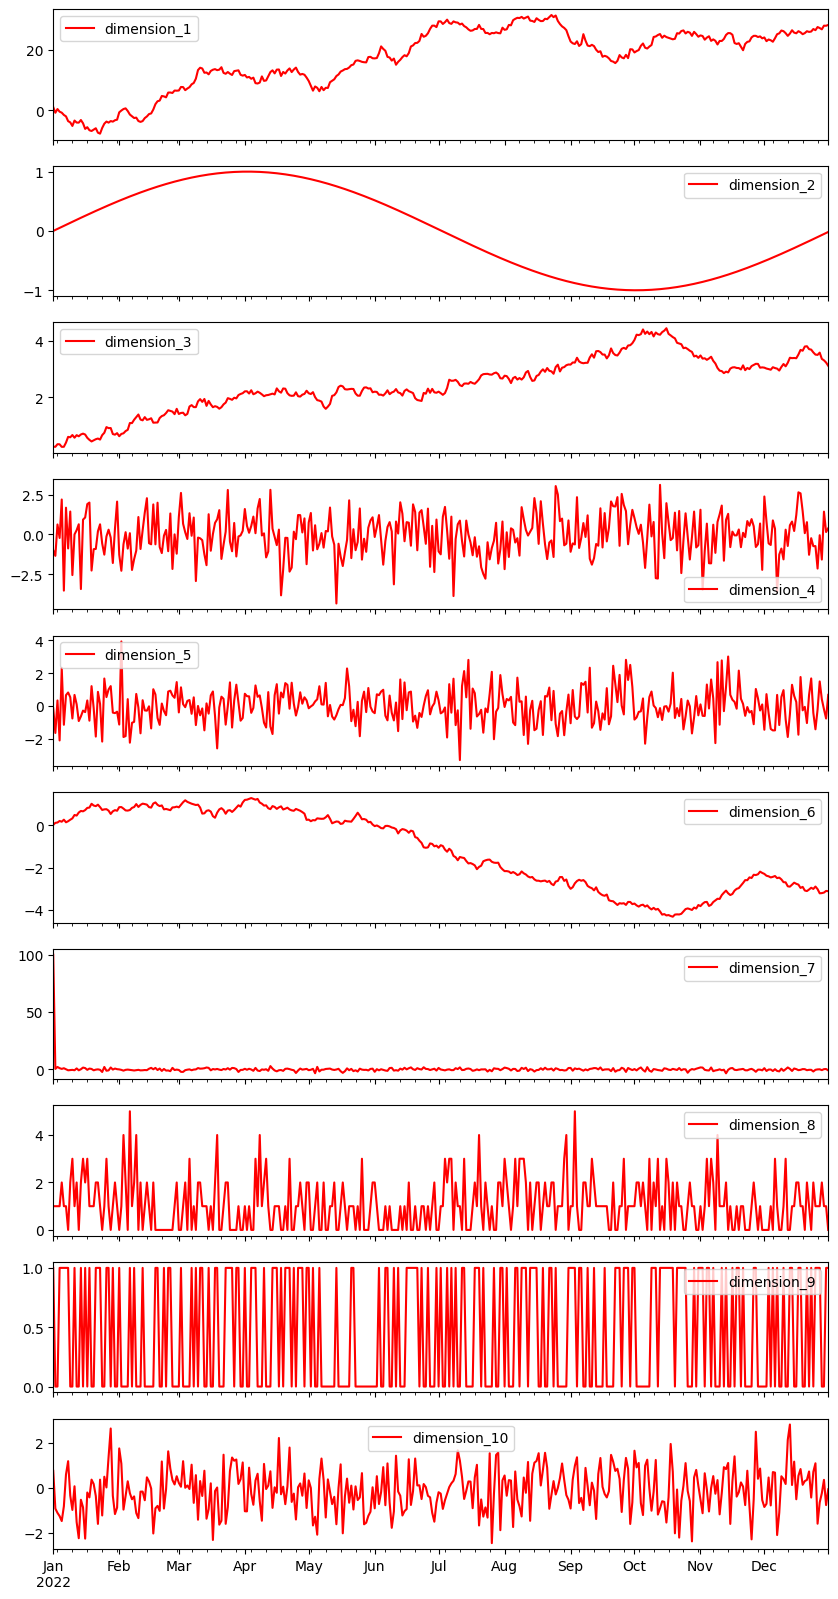

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Define the time range
start_date = '2022-01-01'
end_date = '2022-12-31'
date_range = pd.date_range(start=start_date, end=end_date, freq='D')

# Define the patterns for each data stream using a dictionary of lambda functions
sensors = [
    lambda data: np.cumsum(data),
    lambda data: np.sin(2 * np.pi * (date_range.dayofyear - 1) / 365),
    lambda data: 0.1 * np.cumsum(data) + np.linspace(0, 1, len(date_range)),
    lambda data: np.array([np.random.randn()] + [0.9 * data[j-1] + np.random.randn() for j in range(1, len(date_range))]),
    lambda data: np.array([np.random.randn()] + [np.random.randn() + 0.5 * data[j-1] for j in range(1, len(date_range))]),
    lambda data: 0.1 * np.cumsum(data) + np.sin(2 * np.pi * date_range.dayofyear / 365),
    lambda data: np.array([100 if j == 0 else data[j-1] * np.exp((0.1 - 0.5 * 0.2**2) * 1/365 + 0.2 * np.sqrt(1/365) * np.random.randn()) for j in range(len(date_range))]),
    lambda data: np.random.poisson(1, size=len(date_range)),
    lambda data: np.random.binomial(1, 0.5, size=len(date_range))
]

# Generate 10 random data streams using the lambda functions
data = np.random.randn(len(date_range), 10)
for s, sensor in enumerate(sensors):
    data[:, s] = sensor(data[:, s])

# Convert the data to a Pandas DataFrame
df = pd.DataFrame(data, index=date_range, columns=[f'sensor_{i}' for i in range(1, 11)])

# Plot the data
df.plot(subplots=True, figsize=(10, 20), color="r")
plt.show()


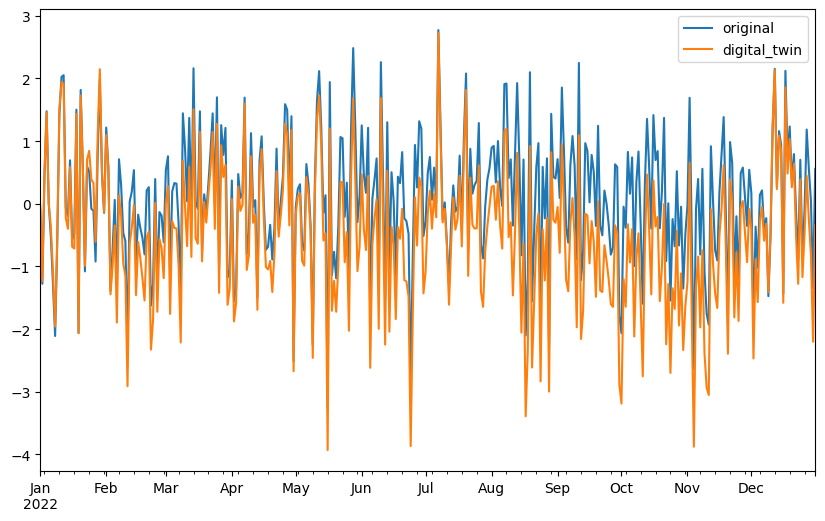

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

NOISE_MAGNITUDE = 0.1

# Define the time range
start_date = '2022-01-01'
end_date = '2022-12-31'
date_range = pd.date_range(start=start_date, end=end_date, freq='D')

og_func = lambda data: np.array([np.random.randn()] + [np.random.randn() + 0.5 * data[j-1] for j in range(1, len(date_range))])

data = og_func(np.zeros(len(date_range)))
noise = np.cumsum(np.random.randn(len(data)))
prediction = data + NOISE_MAGNITUDE * noise

# # Convert the data to a Pandas DataFrame
df = pd.DataFrame({
    'original': data,
    'digital_twin': prediction
    },
    index=date_range
)

# Plot the data
df.plot(figsize=(10, 6))
plt.show()


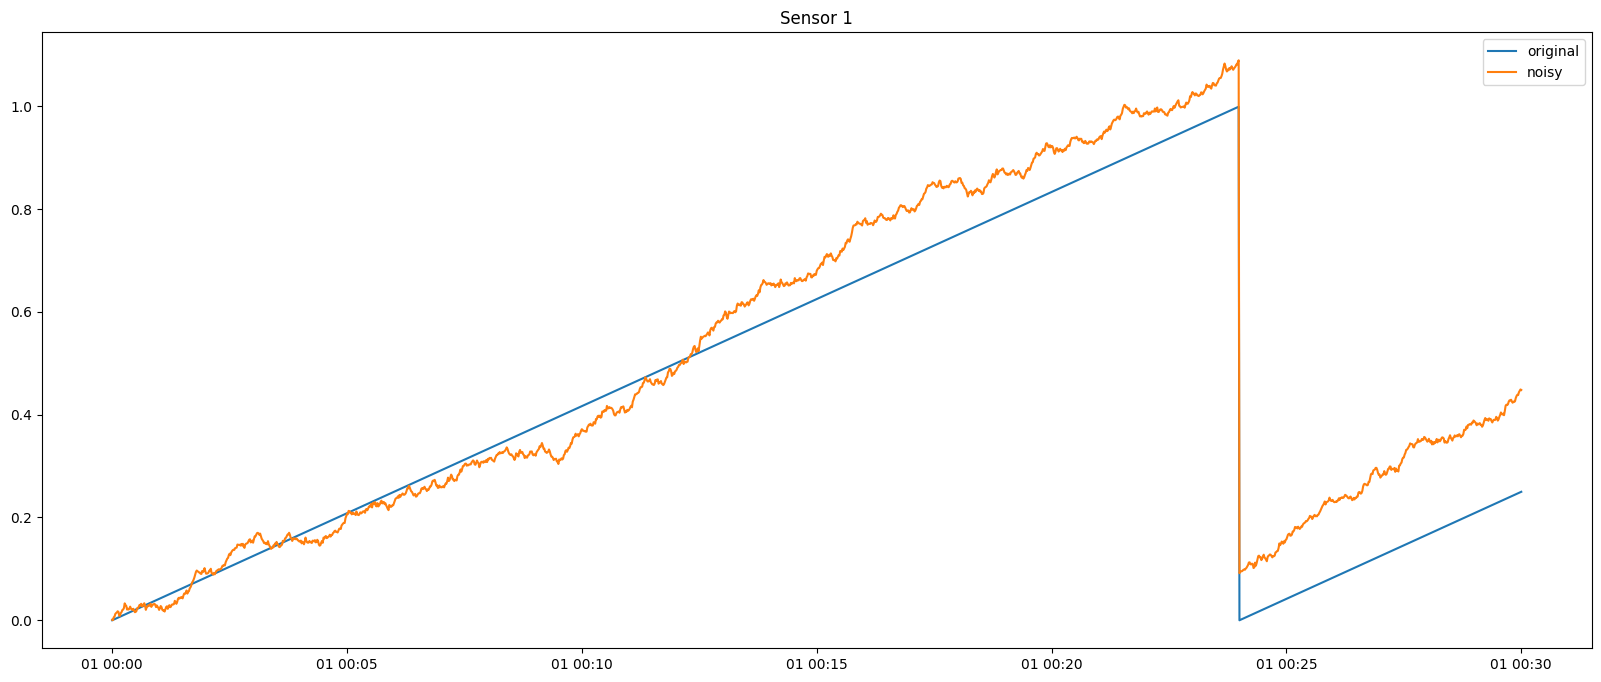

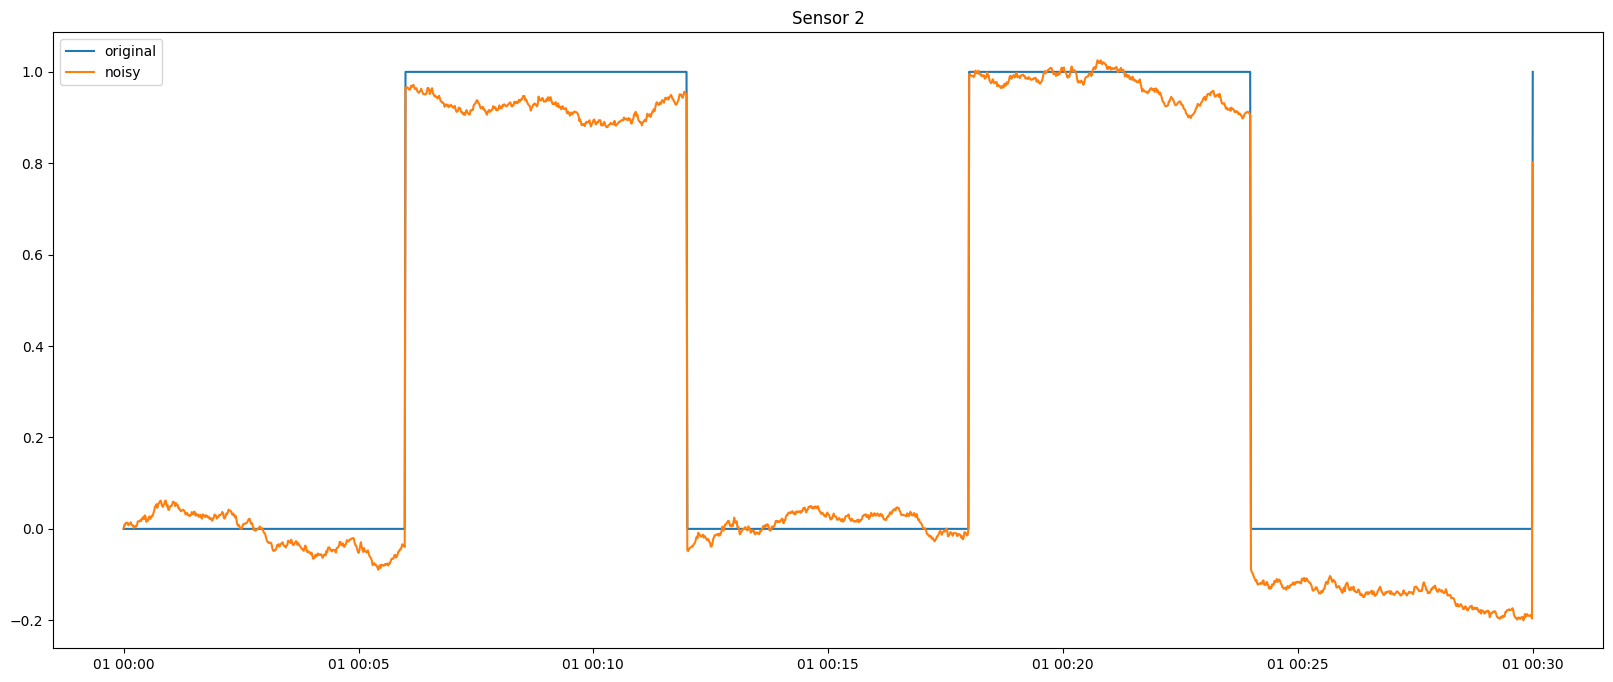

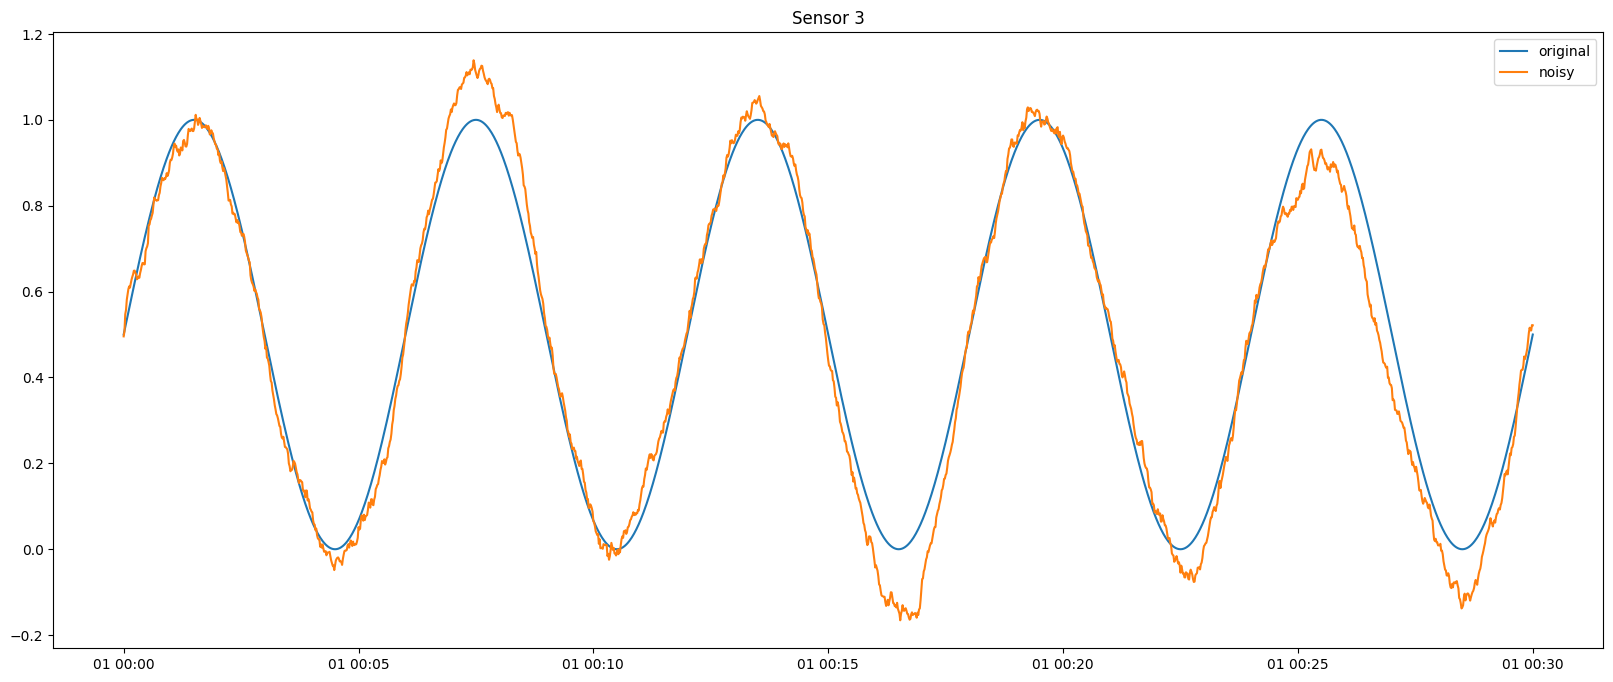

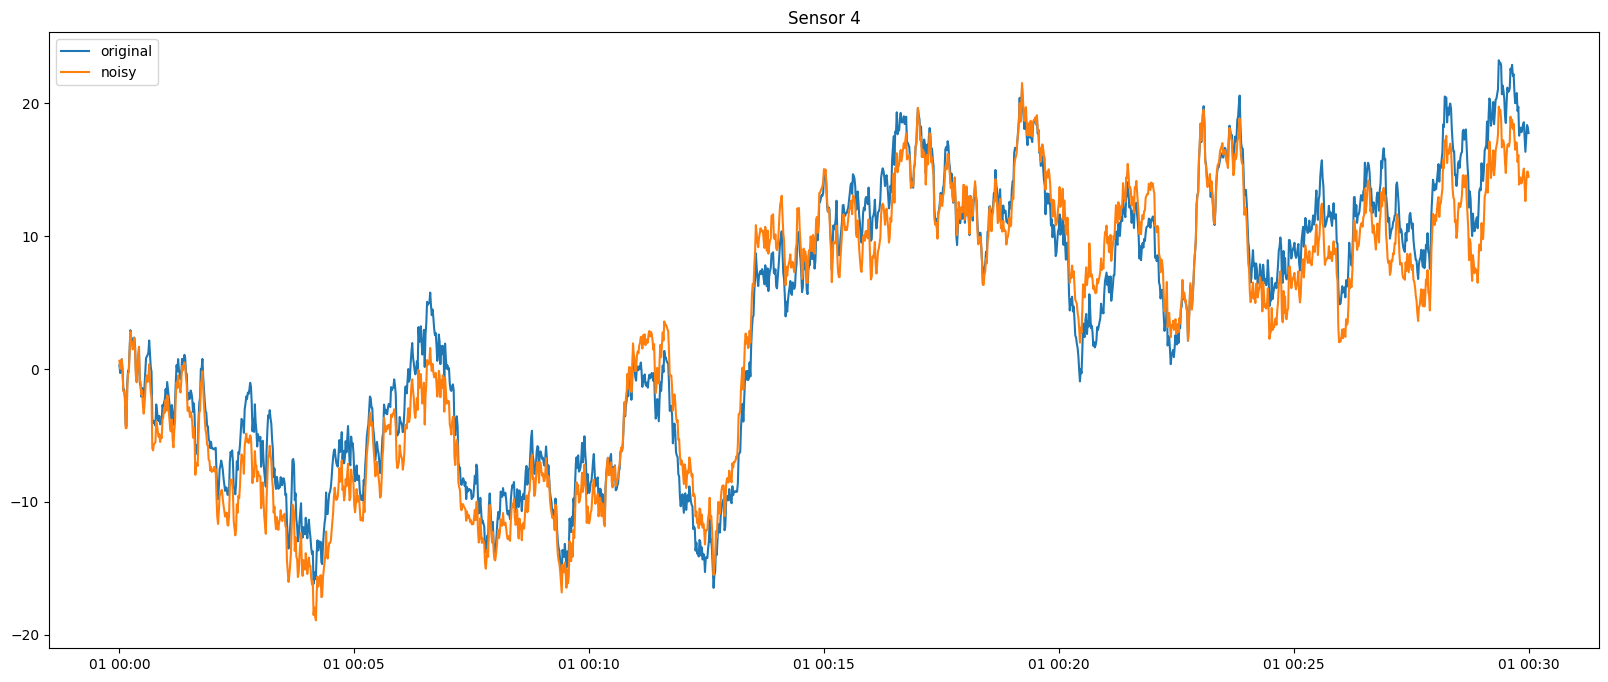

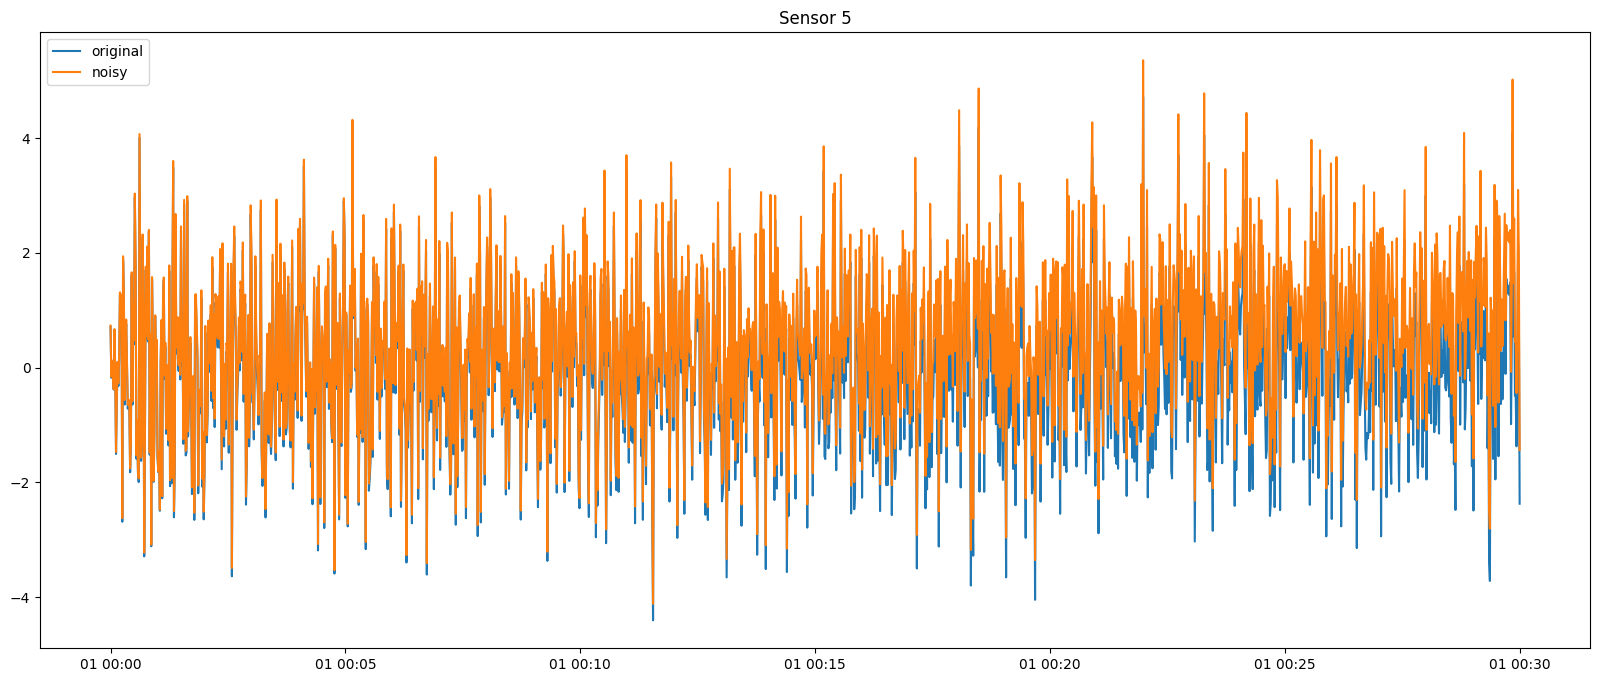

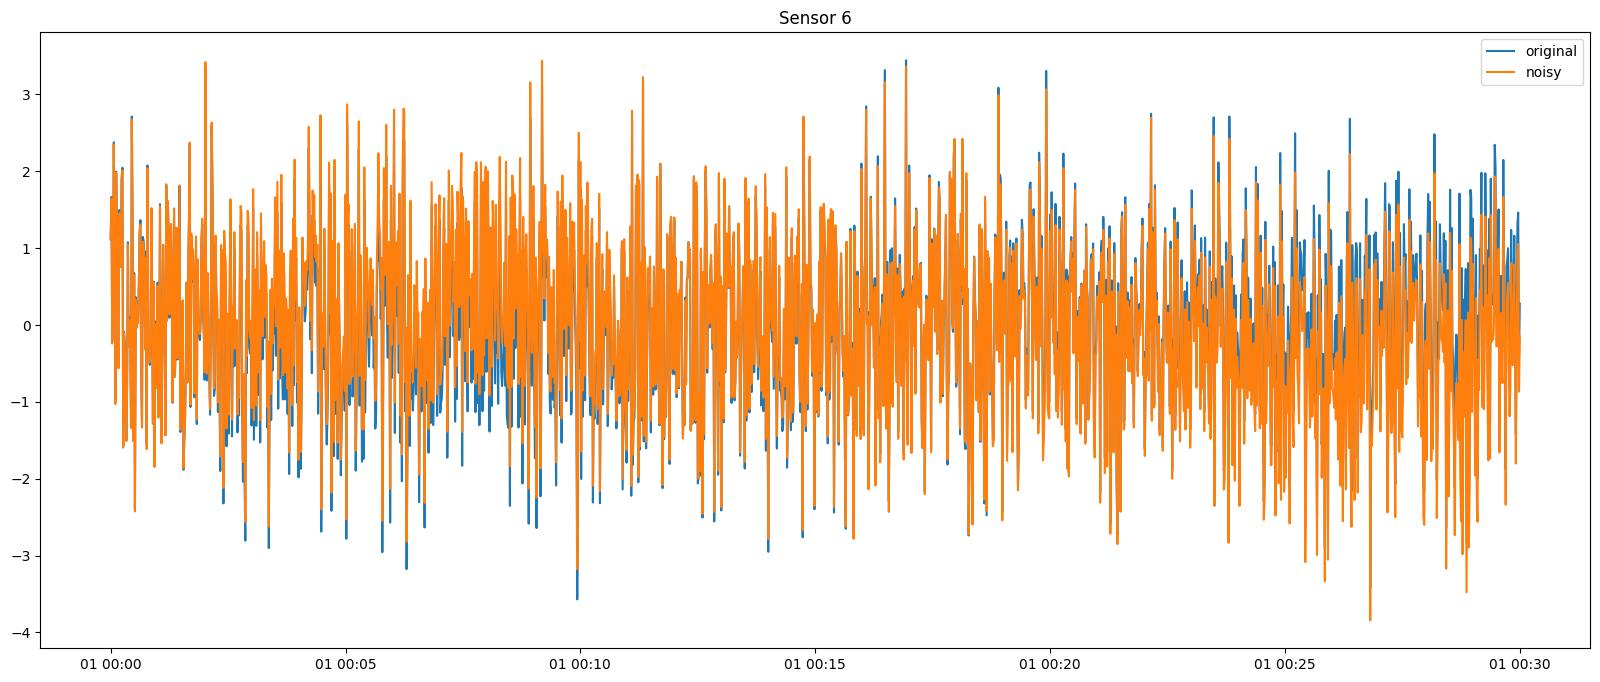

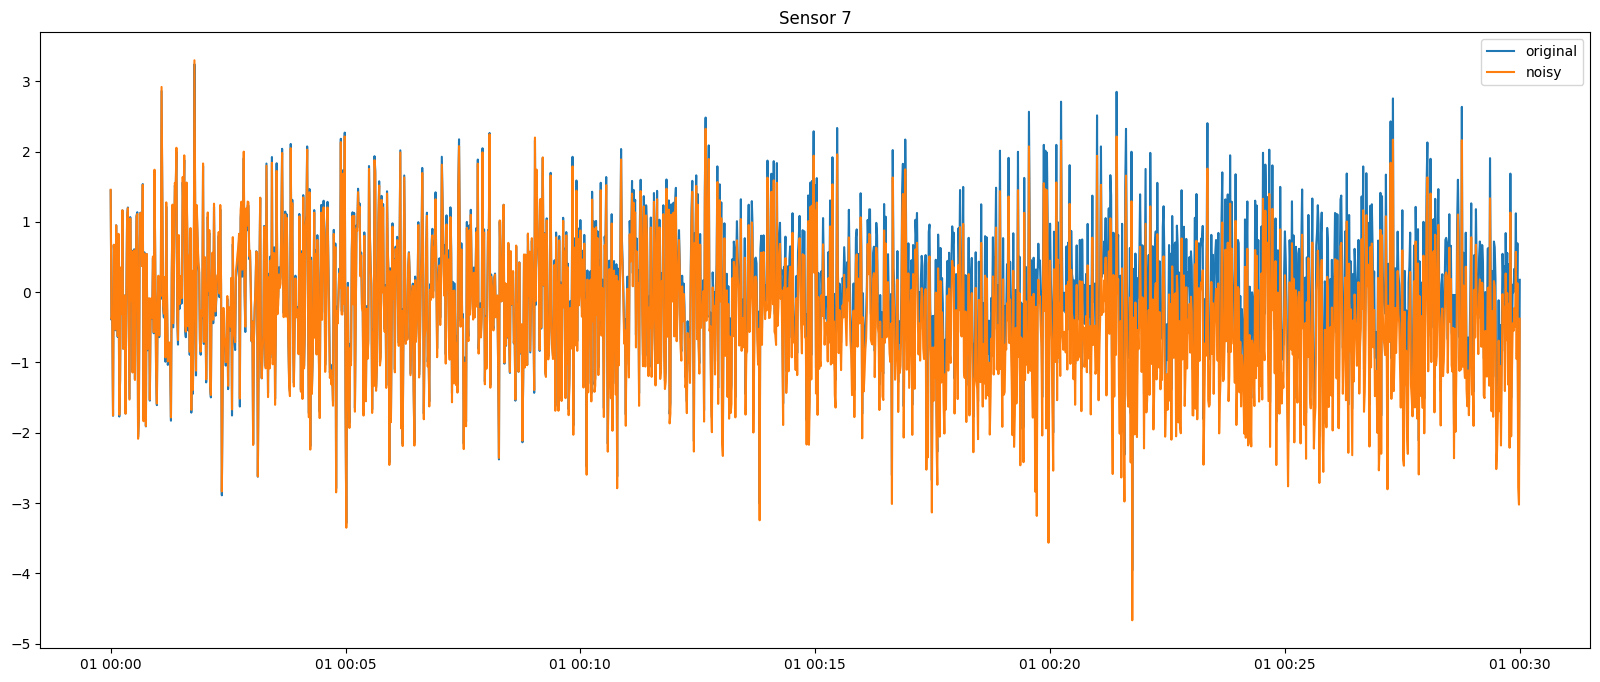

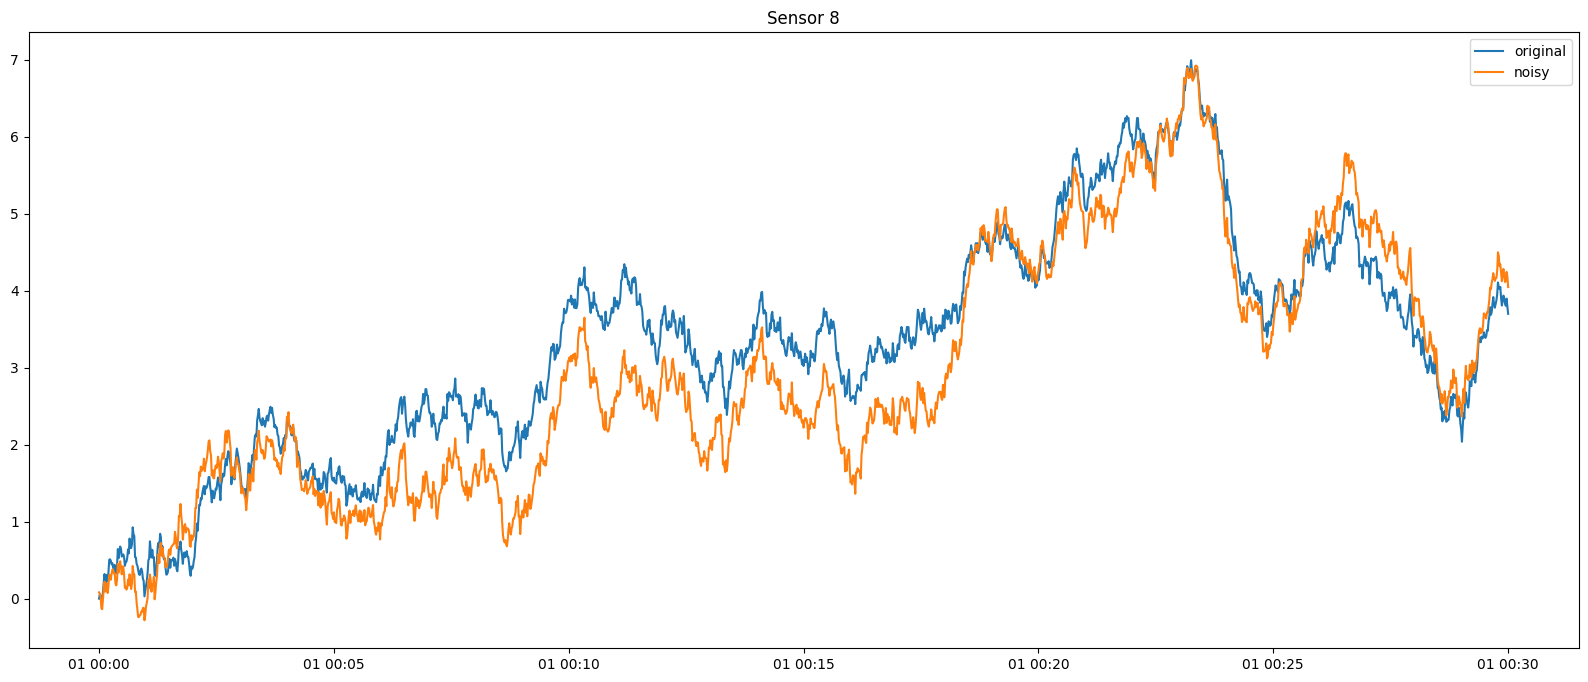

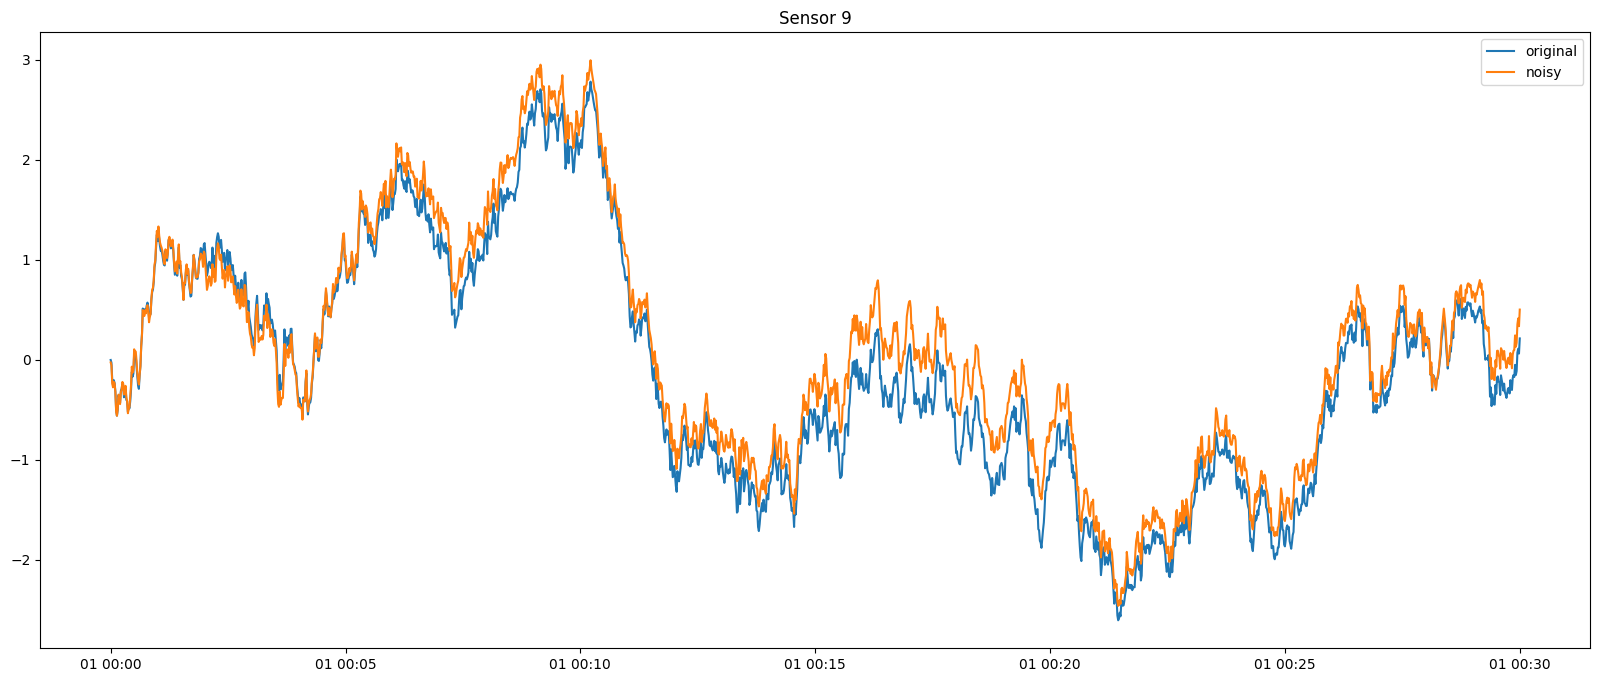

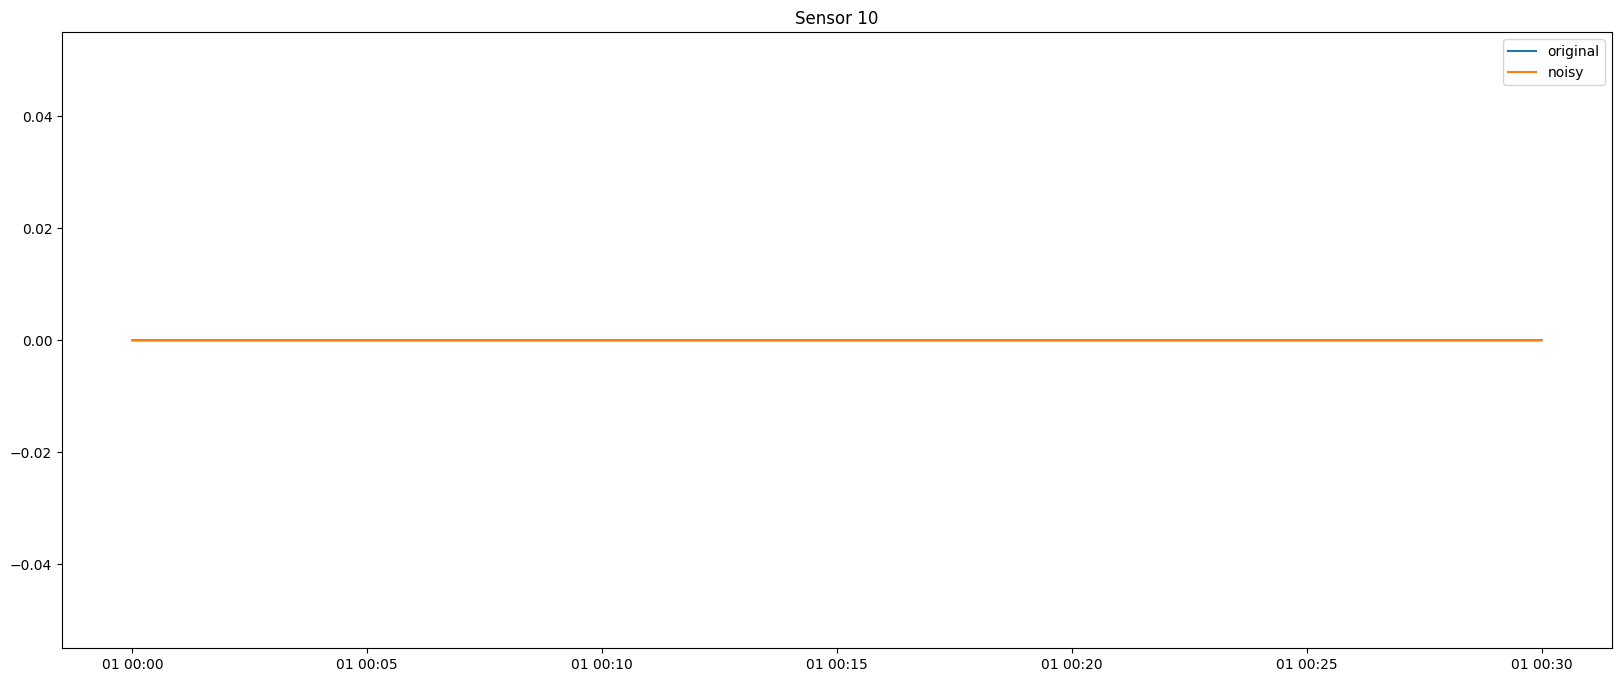

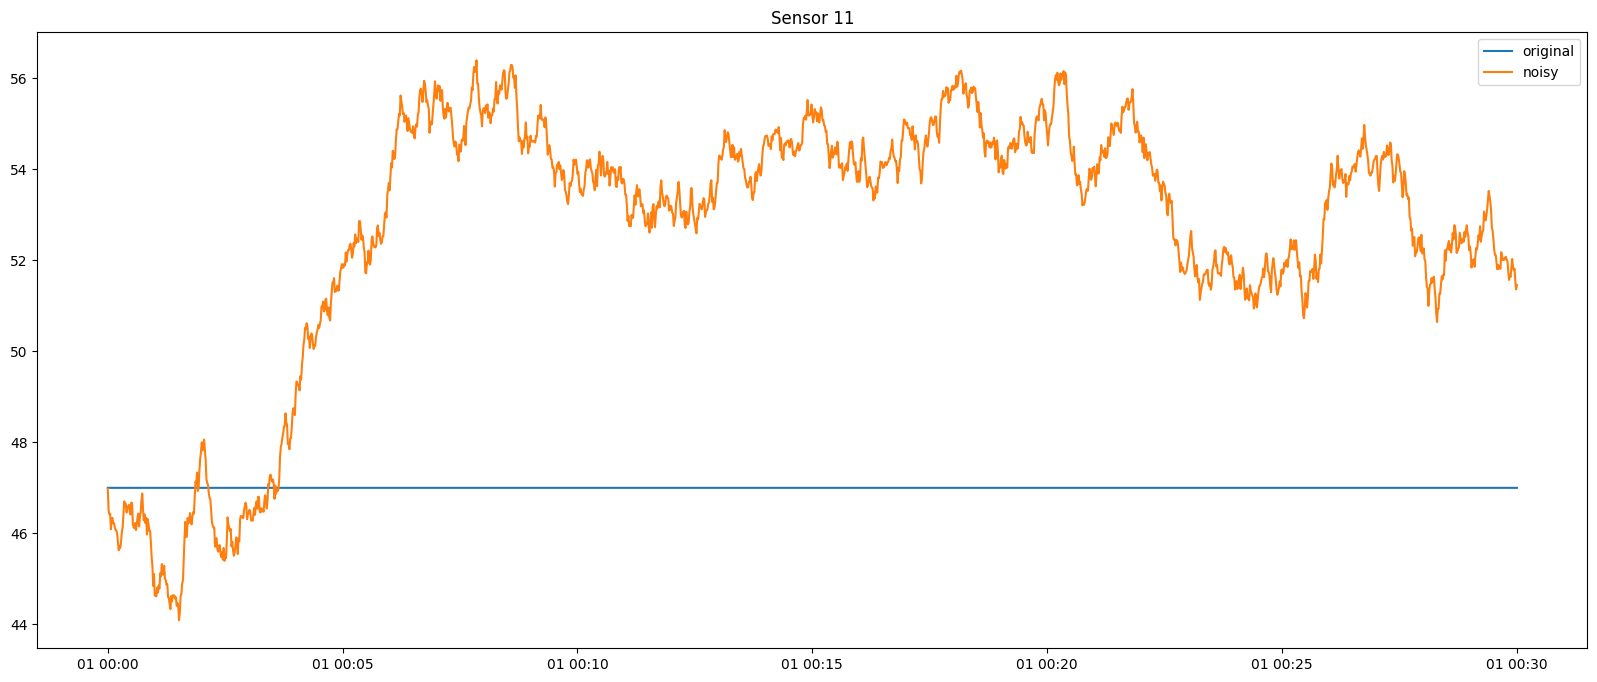

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

NOISE_MAGNITUDE = 0.2

# Define the time range with a one-day interval in seconds
start_date = '2022-01-01 00:00:00'
end_date = '2022-01-01 00:30:00'
date_range = pd.date_range(start=start_date, end=end_date, freq='S')
num_samples = len(date_range)

sensors = [    
    lambda data: (np.arange(num_samples) % (24*60)) / (24*60),
    lambda data: (np.arange(num_samples) % (12*60) >= (12*60)/2).astype(float),
    lambda data: 0.5 * np.sin(2 * np.pi * np.arange(num_samples) / (6*60)) + 0.5,
    lambda data: np.cumsum(data),
    lambda data: np.array([0.9 * data[j] + np.random.randn() for j in range(num_samples)]),
    lambda data: np.array([0.5 * data[j] + np.random.randn() for j in range(num_samples)]),
    lambda data: np.array([data[j] * np.exp((0.1 - 0.5 * 0.2**2) * 1/365 + 0.2 * np.sqrt(1/365) * np.random.randn()) for j in range(num_samples)]),
    lambda data: 0.1 * np.cumsum(data) + np.linspace(0, 1, num_samples),
    lambda data: 0.1 * np.cumsum(data) + np.sin(2 * np.pi * date_range.dayofyear / 365),
    lambda data: np.random.poisson(1),
    lambda data: np.random.binomial(100, 0.5),
]

# Generate 10 random data streams using the lambda functions
data = np.random.randn(len(date_range), len(sensors))
for s, sensor in enumerate(sensors):
    data[:, s] = sensor(data[:, s])

# Plot the data and their noise for each function
for s in range(len(sensors)):
    plt.figure(figsize=(20, 8))
    original_data = data[:, s]
    
    noise = np.cumsum(np.random.randn(len(original_data)))
    ratio = np.max(np.abs(original_data)) / np.max(np.abs(noise))
    prediction = original_data + NOISE_MAGNITUDE * noise * ratio
    
    plt.plot(date_range, original_data, label='original')
    plt.plot(date_range, prediction, label='noisy')
    plt.title(f'Sensor {s+1}')
    plt.legend()
    plt.show()
    


In [4]:
import numpy as np
import pandas as pd
import requests
from datetime import datetime, timedelta
import time

# Constants
NOISE_MAGNITUDE = 0.2
API_URL = 'http://localhost:8000/api'
API_TICK = f"{API_URL}/tick"
API_PREDICTION = f"{API_URL}/prediction"

# Define the time range with a one-day interval in seconds
LOOKAHEAD = 100

sensors = [
    lambda seed, date: (np.arange(1) % (24*60)) / (24*60),
    lambda seed, date: (np.arange(1) % (12*60) >= (12*60)/2).astype(float),
    lambda seed, date: 0.5 * np.sin(2 * np.pi * np.arange(1) / (6*60)) + 0.5,
    lambda seed, date: 0.9 * seed + NOISE_MAGNITUDE * np.random.randn(),
    lambda seed, date: np.random.randn() + 0.5 * seed,
    lambda seed, date: seed * np.exp((0.1 - 0.5 * 0.2**2) * 1/365 + 0.2 * np.sqrt(1/365) * np.random.randn()),
    lambda seed, date: 0.1 * seed + np.sin(2 * np.pi * date.second / 60),
    lambda seed, date: 0.1 * seed + np.linspace(0, 1, 1),
    lambda seed, date: np.random.poisson(1, size=1),
    lambda seed, date: np.random.binomial(4, 0.5, size=1),
]

def real_time_date(start_time=None):
    if not start_time:
        start_time = datetime.now()
        
    current_time = start_time
    while True:
        yield current_time
        current_time += timedelta(seconds=1)
        time.sleep(1)


def generate_data():
    data_seed = np.random.randn(LOOKAHEAD, len(sensors))
    sensor_data = np.zeros(LOOKAHEAD, len(sensors))
    start_time = datetime.now()
    current_time = start_time
    
    # initialize the data, so we can mock predictions
    for s, sensor in enumerate(sensors):
        for i in range(LOOKAHEAD):
            sensor_data[i, s] = sensor(data_seed[i, s], current_time)
            current_time += timedelta(seconds=1)
    
    for current_time in real_time_date(current_time):
        for s, sensor in enumerate(sensors):
            sensor_data[:,s] += sensor(data_seed[0, s], current_time)
            sensor_data.popleft()
            
            data_seed[:,s] += np.random.randn(1)
            data_seed.popleft()

            noise = np.cumsum(np.random.randn(LOOKAHEAD))
            ratio = np.max(np.abs(sensor_data[:,s])) / np.max(np.abs(noise))
            
            prediction = sensor_data[:,s] + NOISE_MAGNITUDE * noise * ratio
            yield sensor_data[:,s], prediction


for sensor_data, prediction in generate_data():
    print(sensor_data, prediction)
    

TypeError: Cannot interpret '10' as a data type